In [1]:
# if 'pip3' does not work, try 'pip'
!pip3 install transformers
!pip3 install pandas

  Using cached https://files.pythonhosted.org/packages/b5/d5/c6c23ad75491467a9a84e526ef2364e523d45e2b0fae28a7cbe8689e7e84/transformers-4.8.1-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/45/b2/6c7545bb7a38754d63048c7696804a0d947328125d81bf12beaa692c3ae3/numpy-1.19.5-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/93/83/71a2ee6158bb9f39a90c0dea1637f81d5eef866e188e1971a1b1ab01a35a/filelock-3.0.12-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/fe/ca/75fac5856ab5cfa51bbbcefa250182e50441074fdc3f803f6e76451fab43/dataclasses-0.8-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/23/5d/f2151217058e7d5c5b4b584bc6052c2ae478c5a36b58a056364351613bfb/importlib_metadata-4.5.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/3e/89/7ea760b4daa42653ece2380531c90f64788d979110a2ab51049d92f408af/packaging-20.9-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.

In [1]:
import numpy as np
import pandas as pd
import torch

import matplotlib.pyplot as plt

from transformers import pipeline, AutoTokenizer, AutoModel

In /home/czh/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/czh/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/czh/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/czh/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/czh/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classi

In [2]:
data_df = pd.read_csv('data/PRIMERAVUELTA2018-FINAL.csv')
tweet_times = data_df['tweet_time'].tolist()
tweet_texts = data_df['text'].tolist()
orig_n = len(tweet_times)

comb_data = list(zip(tweet_times, tweet_texts))
comb_data = [cd for cd in comb_data if str(cd[0]) != 'nan' and type(cd[1]) == str and cd[1].strip() != '']
tweet_times, tweet_texts = map(list, zip(*comb_data))
cleaned_n = len(tweet_times)
print('Orig n tweets: {} cleaned n tweets: {} (n removed: {})'.format(orig_n,
                                                                     cleaned_n,
                                                                     orig_n - cleaned_n))

print('tweet_times[:6]: {}'.format(tweet_times[:6]))
print('tweet_texts[:6]: {}'.format(tweet_texts[:6]))

/home/czh/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (27) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Orig n tweets: 903609 cleaned n tweets: 903243 (n removed: 366)
tweet_times[:6]: ['2018-03-04 22:50:23', '2018-03-04 22:51:05', '2018-03-04 22:51:27', '2018-03-04 22:51:33', '2018-03-04 22:52:20', '2018-03-04 22:53:18']
tweet_texts[:6]: ['RT @linaguevaras: Cierre de campaña de nuestro proximo presidente de colombia #DuquePresidente #DuqueEsElQueEs \U0001f9e1 https://t.co/bL6LobpMch', 'RT @PalomaValenciaL: Chiquinquira dice #DuquePresidente @IvanDuque @CeDemocratico https://t.co/LiM65PbcVW', 'RT @PaolaHolguin: Al ritmo de #DuquePresidente vamos en nuestra caravana, con la convicción que el próximo 11 de marzo ganaremos la c… https://t.co/nT2s6cjJ6d', 'RT @PalomaValenciaL: Gracias Ronald amigo de Amapola vamos por una Colombia llena de futuro para ustedes #DuquePresidente https://t.co/0Ee9VSSu3y', 'RT @PalomaValenciaL: Gracias Ronald amigo de Amapola vamos por una Colombia llena de futuro para ustedes #DuquePresidente https://t.co/0Ee9VSSu3y', 'RT @PalomaValenciaL: Gracias Ronald amigo d

In [5]:
def parse_result_to_sentiment(results):
    sentiments = []
    for result_set in results:
        sent = {'neg': 0.0, 'neut': 0.0, 'pos': 0.0}
        for result in result_set:
            if result['label'] in ['1 star', '2 stars']:
                sent['neg'] += result['score']
            elif result['label'] in ['4 stars', '5 stars']:
                sent['pos'] += result['score']
            else:
                sent['neut'] += result['score']
        sentiments.append(sent)
    
    return sentiments


def analyze_sentiment(model_name, texts, batch_size=512):
    print('Creating pipeline...')
    pipe = pipeline('sentiment-analysis',
                   model=model_name, 
                   tokenizer=model_name,
                    return_all_scores=True,
                   device=0)
    print('Analyzing texts...')
    results = []
    batch_idx = 0
    n_batches = len(texts) // batch_size
    for batch_start_idx in range(0, len(texts), batch_size):
        if batch_idx % 10 == 0:
            print('Processing batch {} of {}...'.format(batch_idx, n_batches))
        batch_texts = texts[batch_start_idx:(batch_start_idx + batch_size)]
    
        batch_results = pipe(batch_texts)
        results.extend(batch_results)
        torch.cuda.empty_cache()
        batch_idx += 1

    sentiments = parse_result_to_sentiment(results)
    
    return sentiments

def parse_times(time_list, hour_bucket_size=8):
    parsed_times = []
    for tweet_time in time_list:
        if str(tweet_time) != 'nan':
            tweet_time = str(tweet_time)
            tmp = tweet_time.split(' ')
            if len(tmp) == 1:
                input('tweet_time: {} tmp: {}'.format(tweet_time, tmp))
            date_data, time_data = tmp
            hours, minutes, seconds = map(int, time_data.split(':'))
            hours = (hours // hour_bucket_size) * hour_bucket_size
            parsed_time = '{0} {1:02d}:00'.format(date_data, hours)
            parsed_times.append(parsed_time)
        
    return parsed_times

In [6]:
sentiment_analysis_model_name = 'nlptown/bert-base-multilingual-uncased-sentiment'
# tmp_tweet_times = tweet_times[:1000]
# tmp_tweet_texts = tweet_texts[:1000]

print('tweet_times[:6]: {}'.format(tweet_times[:6]))
print('tweet_texts[:6]: {}'.format(tweet_texts[:6]))

parsed_times = parse_times(tweet_times)
sentiments = analyze_sentiment(sentiment_analysis_model_name, 
                                   tweet_texts)

print('parsed_times[:6]: {}'.format(parsed_times[:6]))
print('sentiments[:6]: {}'.format(sentiments[:6]))

tweet_times[:6]: ['2018-03-04 22:50:23', '2018-03-04 22:51:05', '2018-03-04 22:51:27', '2018-03-04 22:51:33', '2018-03-04 22:52:20', '2018-03-04 22:53:18']
tweet_texts[:6]: ['RT @linaguevaras: Cierre de campaña de nuestro proximo presidente de colombia #DuquePresidente #DuqueEsElQueEs \U0001f9e1 https://t.co/bL6LobpMch', 'RT @PalomaValenciaL: Chiquinquira dice #DuquePresidente @IvanDuque @CeDemocratico https://t.co/LiM65PbcVW', 'RT @PaolaHolguin: Al ritmo de #DuquePresidente vamos en nuestra caravana, con la convicción que el próximo 11 de marzo ganaremos la c… https://t.co/nT2s6cjJ6d', 'RT @PalomaValenciaL: Gracias Ronald amigo de Amapola vamos por una Colombia llena de futuro para ustedes #DuquePresidente https://t.co/0Ee9VSSu3y', 'RT @PalomaValenciaL: Gracias Ronald amigo de Amapola vamos por una Colombia llena de futuro para ustedes #DuquePresidente https://t.co/0Ee9VSSu3y', 'RT @PalomaValenciaL: Gracias Ronald amigo de Amapola vamos por una Colombia llena de futuro para ustedes #D

# unique times: 253


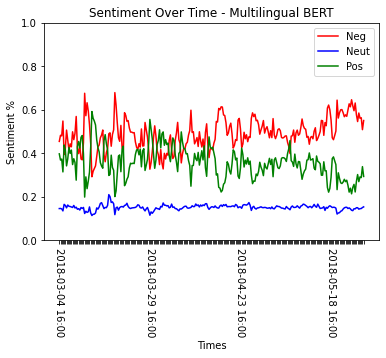

In [9]:
def plot_sentiment_over_time(all_sentiments, all_times, xtick_every=75):
    unique_times = list(np.unique(all_times))
    unique_times = list(sorted(unique_times))
    print('# unique times: {}'.format(len(unique_times)))
    sentiments_by_time = {ut: {'neg': [], 'neut': [], 'pos': []} for ut in unique_times}
    
    for t_time, t_sentiments in zip(all_times, all_sentiments):
        sentiments_by_time[t_time]['neg'].append(t_sentiments['neg'])
        sentiments_by_time[t_time]['neut'].append(t_sentiments['neut'])
        sentiments_by_time[t_time]['pos'].append(t_sentiments['pos'])
    
    xs, xticks, neg_vals, neut_vals, pos_vals = [], [], [], [], []
    for time_idx, unique_time in enumerate(unique_times):
#         print('time_idx: {}'.format(time_idx))
#         print('unique_time: {}'.format(unique_time))
        t_neg_vals = sentiments_by_time[unique_time]['neg']
        t_neut_vals = sentiments_by_time[unique_time]['neut']
        t_pos_vals = sentiments_by_time[unique_time]['pos']
        
        neg_avg_this_time = sum(t_neg_vals) / len(t_neg_vals)
        neut_avg_this_time = sum(t_neut_vals) / len(t_neut_vals)
        pos_avg_this_time = sum(t_pos_vals) / len(t_pos_vals)
        
        xs.append(time_idx)
        xticks.append(unique_time if time_idx % xtick_every == 0 else '')
        neg_vals.append(neg_avg_this_time)
        neut_vals.append(neut_avg_this_time)
        pos_vals.append(pos_avg_this_time)
    
#     print('xs: {}'.format(xs))
#     print('neg_vals: {}'.format(neg_vals))
    
    plt.plot(xs, neg_vals, color='red', label='Neg')
    plt.plot(xs, neut_vals, color='blue', label='Neut')
    plt.plot(xs, pos_vals, color='green', label='Pos')
    plt.xticks(xs, xticks, rotation=-90)
    plt.xlabel('Times')
    plt.ylabel('Sentiment %')
    plt.title('Sentiment Over Time - Multilingual BERT')
    plt.ylim(0.0, 1.0)
    plt.legend()
    plt.show()
    
plot_sentiment_over_time(sentiments, parsed_times)